In [42]:
from __future__ import division
import numpy as np
from numpy import pi, cos, sin, exp, conj
from warnings import warn
from epgcpmg import *
import time
import sys
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

In [129]:
def relax_prime_T1(FpFmZ, T, T1, T2):
    # returns E'(T1) FpFmZ + E0'(T1)
    
    EE_prime_T1 = relax_mat_prime_T1(T, T1, T2)
    
    RR = -EE_prime_T1[2,2]
    
    FpFmZ = np.dot(EE_prime_T1, FpFmZ)
    FpFmZ[2,0] = FpFmZ[2,0] + RR
    
    return FpFmZ

def relax_prime_T2(FpFmZ, T, T1, T2):
    # returns E'(T2) FpFmZ
    
    EE_prime_T2 = relax_mat_prime_T2(T, T1, T2)
    FpFmZ = np.dot(EE_prime_T2, FpFmZ)
    
    return FpFmZ

def relax_mat_prime_T1(T, T1, T2):
    
    E1_prime_T1 = T*exp(-T/T1)/T1**2
    return np.diag([0, 0, E1_prime_T1])

def relax_mat_prime_T2(T, T1, T2):
    
    E2_prime_T2 = T*exp(-T/T2)/T2**2
    return np.diag([E2_prime_T2, E2_prime_T2, 0])

    
def FSE_TE_prime1_T2(FpFmZ, alpha, TE, T1, T2, noadd=False):
    """ Returns E(T2) G R G E'(T2) FpFmZ"""
    
    EE = relax_mat(TE/2., T1, T2)
    EE_prime = relax_mat_prime_T2(TE/2., T1, T2)

    FpFmZ = np.dot(EE_prime, FpFmZ)    
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = rf(FpFmZ, alpha)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = np.dot(EE, FpFmZ)
    
    return FpFmZ

def FSE_TE_prime2_T2(FpFmZ, alpha, TE, T1, T2, noadd=False):
    """ Returns E'(T2) G R G (E(T2) FpFmZ + E0)"""
    
    EE_prime = relax_mat_prime_T2(TE/2., T1, T2)
    
    FpFmZ = relax(FpFmZ, TE/2., T1, T2)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = rf(FpFmZ, alpha)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = np.dot(EE_prime, FpFmZ)
    
    return FpFmZ

def FSE_TE_prime1_T1(FpFmZ, alpha, TE, T1, T2, noadd=False):
    """ Returns E(T1) G R G (E'(T1) FpFmZ + E0'(T1))"""
    
    EE = relax_mat(TE/2., T1, T2)
    
    FpFmZ = relax_prime_T1(FpFmZ, TE/2., T1, T2) # E'(T1) FpFmZ + E0'(T1)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = rf(FpFmZ, alpha)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = np.dot(EE, FpFmZ)
    
    return FpFmZ

def FSE_TE_prime2_T1(FpFmZ, alpha, TE, T1, T2, noadd=False):
    """ Returns E'(T1) G R G E(T1) FpFmZ + E0'(T1)"""
    
    EE = relax_mat(TE/2., T1, T2)

    FpFmZ = np.dot(EE, FpFmZ) 
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = rf(FpFmZ, alpha)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = relax_prime_T1(FpFmZ, TE/2., T1, T2) # E'(T1) FpFmZ + E0'(T1)
    
    return FpFmZ

In [130]:
def FSE_prime_T2(angles_rad, TE, T1, T2):
    """Derivative of EPG function w.r.t. T2"""
    
    T = len(angles_rad)
    
    zi = np.hstack((np.array([[1],[1],[0]]), np.zeros((3, T))))
    z_prime = np.zeros((T, 1))
    
    for i in range(T):
      
        alpha = angles_rad[i]

        if i == 0:
            wi = np.zeros((3, T+1))
        else:
            wi = FSE_TE(wi, alpha, TE, T1, T2, noadd=True, recovery=False)

        wi += FSE_TE_prime1_T2(zi, alpha, TE, T1, T2, noadd=True)
        wi += FSE_TE_prime2_T2(zi, alpha, TE, T1, T2, noadd=True)
        
        zi = FSE_TE(zi, alpha, TE, T1, T2, noadd=True)
        z_prime[i] = wi[0,0]

    return z_prime

def FSE_prime_T1(angles_rad, TE, T1, T2):
    """Derivative of EPG function w.r.t. T1"""
    
    T = len(angles_rad)
    
    zi = np.hstack((np.array([[1],[1],[0]]), np.zeros((3, T))))
    z_prime = np.zeros((T, 1))
    
    for i in range(T):
        
        alpha = angles_rad[i]

        if i == 0:
            wi = np.zeros((3, T+1))
        else:
            wi = FSE_TE(wi, alpha, TE, T1, T2, noadd=True, recovery=False)
            
        wi += FSE_TE_prime1_T1(zi, alpha, TE, T1, T2, noadd=True)
        wi += FSE_TE_prime2_T1(zi, alpha, TE, T1, T2, noadd=True)

        zi = FSE_TE(zi, alpha, TE, T1, T2, noadd=True)
        z_prime[i] = wi[0,0]

    return z_prime

In [131]:
def numerical_gradient(myfun, myparams):

    initial_params = myparams.copy()
    num_grad = np.zeros(initial_params.shape)
    perturb = np.zeros(initial_params.shape)
    e = 1e-5
    
    for p in range(len(initial_params)):
        
        perturb[p] = e
        
        loss2 = myfun(myparams + perturb)
        loss1 = myfun(myparams - perturb)
        
        num_grad[p] = (loss2 - loss1) / (2 * e)
        
        perturb[p] = 0.

        return num_grad

prop grad time: 0.0147130489349
num grad time: 0.929065942764


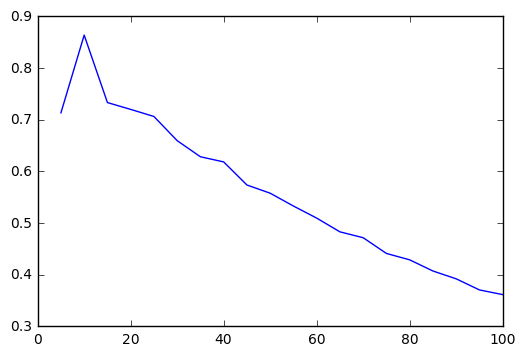

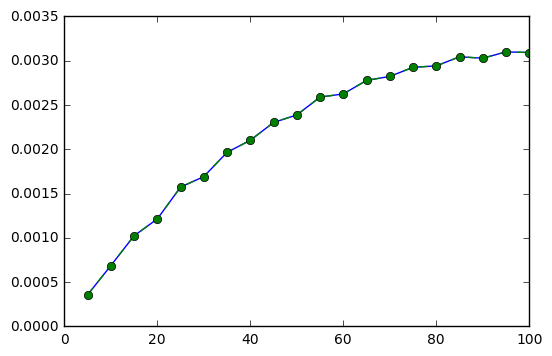

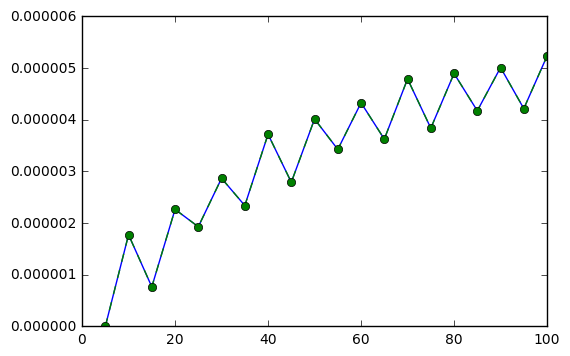

In [157]:
T1 = 1000
T2 = 100
TE = 5

T = 20

# 0.26947104
# 0.52563555
# 0.76898634

echo_times = np.arange(TE, TE*(T+1), TE)

angles_rad = 120 * np.ones((T,)) * np.pi/180

z1 = FSE_signal(angles_rad, TE, T1, T2)

tic = time.time()
w1 = FSE_prime_T1(angles_rad, TE, T1, T2)
w2 = FSE_prime_T2(angles_rad, TE, T1, T2)
toc = time.time()
print 'prop grad time:', toc-tic
# w2_th = echo_times / (T2**2) * exp(-echo_times/T2)

tic = time.time()
w1_num = np.zeros((T,))
w2_num = np.zeros((T,))
for i in range(T):
    w2_num[i] = numerical_gradient(lambda x: FSE_signal(angles_rad, TE, T1, x)[i], np.array([T2]))
    w1_num[i] = numerical_gradient(lambda x: FSE_signal(angles_rad, TE, x, T2)[i], np.array([T1]))
toc = time.time()

print 'num grad time:', toc-tic
# print w2_num
# print w2.T

# print w1_num
# print w1.T

plt.plot(echo_times, z1)
plt.figure()
plt.plot(echo_times, w2, echo_times, w2_num, 'o--')

plt.figure()
plt.plot(echo_times, w1, echo_times, w1_num, 'o--')




In [141]:
def read_angles(fliptable):
    f = open(fliptable, 'r')
    angles = []
    for line in f.readlines():
        angles.append(float(line))
    f.close()
    return np.array(angles)

In [148]:
angles_rad = np.pi/180 * read_angles('flipangles.txt.814192544')
T = len(angles_rad)
TE = 5
T1 = 1000
T2 = 200

echo_times = np.arange(TE, TE*(T+1), TE)


prop grad time: 0.0587749481201


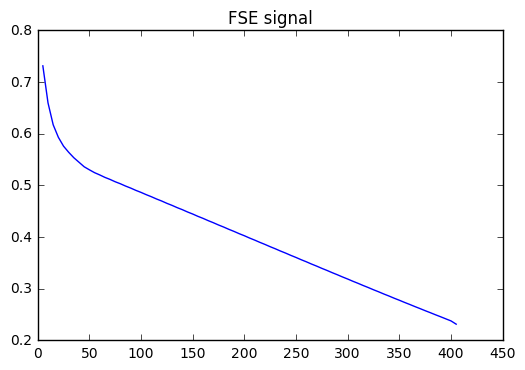

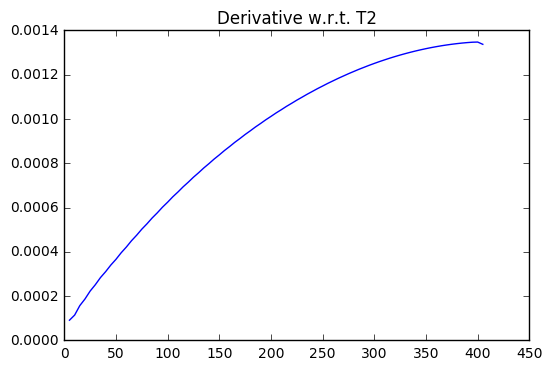

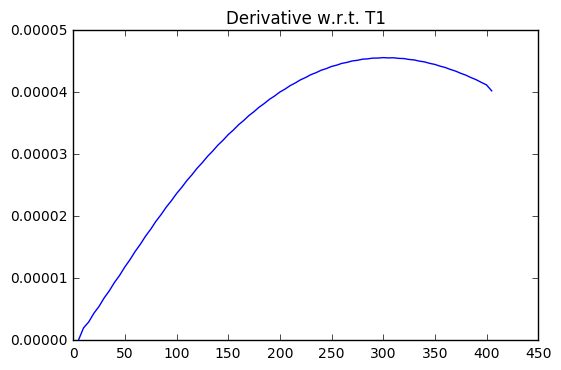

In [150]:
z1 = FSE_signal(angles_rad, TE, T1, T2)

tic = time.time()
w1 = FSE_prime_T1(angles_rad, TE, T1, T2)
w2 = FSE_prime_T2(angles_rad, TE, T1, T2)
toc = time.time()
print 'prop grad time:', toc-tic


plt.figure()
plt.plot(echo_times, z1)
plt.title('FSE signal')

plt.figure()
plt.plot(echo_times, w2)
plt.title('Derivative w.r.t. T2')

plt.figure()
plt.plot(echo_times, w1)
plt.title('Derivative w.r.t. T1')

